In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import os.path
from os.path import join
import numpy as np
import imodelsx
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import data
import joblib
files_dict = data.load_files_dict_single_site()

### Filter data for single-site analysis

In [ ]:
site = 'Atlanta'
# site = 'Columbus'
# site = 'WashingtonDC'
df = files_dict[site]
theme_index = np.where(
    np.array(list(map(str.lower, df.columns.values))) == 'theme')[0][0]
col_vals = df.columns[4: theme_index]

# separate into relevant pieces
qs = df['Subcategory']
responses_df = df[col_vals]
themes_df = df[df.columns[theme_index:]]

### Run sentiment
Note: this uses a lot of API calls (num questions * num responses), maybe around 400

In [ ]:
sentiment_prompt = '''### You are given a question and a response. Rate the sentiment/supportiveness of the response on a scale of 1 to 5, where 1 is very negative and 5 is very positive. ###

Question: {question}

Response: {response}

Rating (1-5):'''

llm = imodelsx.llm.get_llm('gpt-4', repeat_delay=None)

num_questions = len(qs)
sentiments = defaultdict(list)
for question_num in tqdm(range(num_questions), position=0):
    question, responses, theme_dict = data.get_data_for_question_single_site(
        question_num=question_num, qs=qs, responses_df=responses_df, themes_df=themes_df)

    for response_num in tqdm(range(len(responses)), position=1):
        response = responses.values[response_num]

        if pd.isna(response):
            sentiments[question_num].append(np.nan)
        else:
            prompt = sentiment_prompt.format(
                question=question, response=response)
            ans = llm(prompt)
            sentiments[question_num].append(ans)

### Plot sentiment

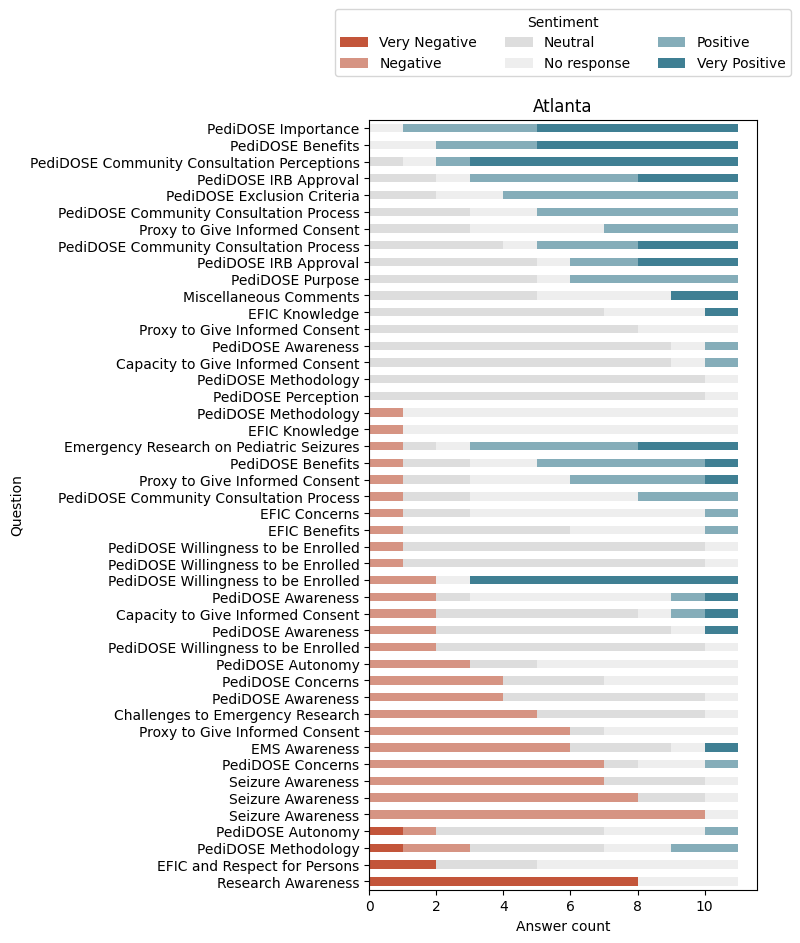

In [33]:
sent_df = pd.DataFrame([(key, var) for (key, L) in sentiments.items() for var in L],
                       columns=['Question', 'Value'])

# round  values
sent_df['Value'] = sent_df['Value'].astype(float).round()
value_maps = {
    1: 'Very Negative',
    2: 'Negative',
    3: 'Neutral',
    4: 'Positive',
    5: 'Very Positive',
}
sent_df['Value'] = sent_df['Value'].map(value_maps.get)
sent_df['Value'] = sent_df['Value'].fillna('No response')

sent_df = sent_df.groupby(['Question', 'Value']).size().unstack(fill_value=0)
levels = ['Very Negative', 'Negative', 'Neutral',
          'No response', 'Positive', 'Very Positive']
sent_df = sent_df.reindex(levels, axis=1)
joblib.dump(sent_df, join(data.PROCESSED_DIR, f'sent_df_{site}.pkl'))

# make plot
sent_df = sent_df.sort_values(by=levels, ascending=False)
colors = sns.diverging_palette(20, 220, n=6).as_hex()
colors = colors[:2] + ['#ddd', '#eee'] + colors[-2:]
sent_df.plot(kind='barh', stacked=True, figsize=(5, 10), color=colors)

plt.yticks(range(46), labels=df['Domain'].values[sent_df.index.values])
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncol=3, title='Sentiment')
plt.xlabel('Answer count')
plt.title(site)
plt.savefig(f'../figs/sentiment_example_{site}.pdf', bbox_inches='tight')
plt.show()

### Aggregate sentiment plots

In [49]:
sent_dfs = []
sites = ['Atlanta', 'Columbus', 'WashingtonDC']
for site in sites:
    sent_df = joblib.load(join(data.PROCESSED_DIR, f'sent_df_{site}.pkl'))
    # sent_df = sent_df.sort_values(by=levels, ascending=False)
    sent_dfs.append(sent_df)

sum_df = pd.concat(sent_dfs).groupby(level=0).sum()

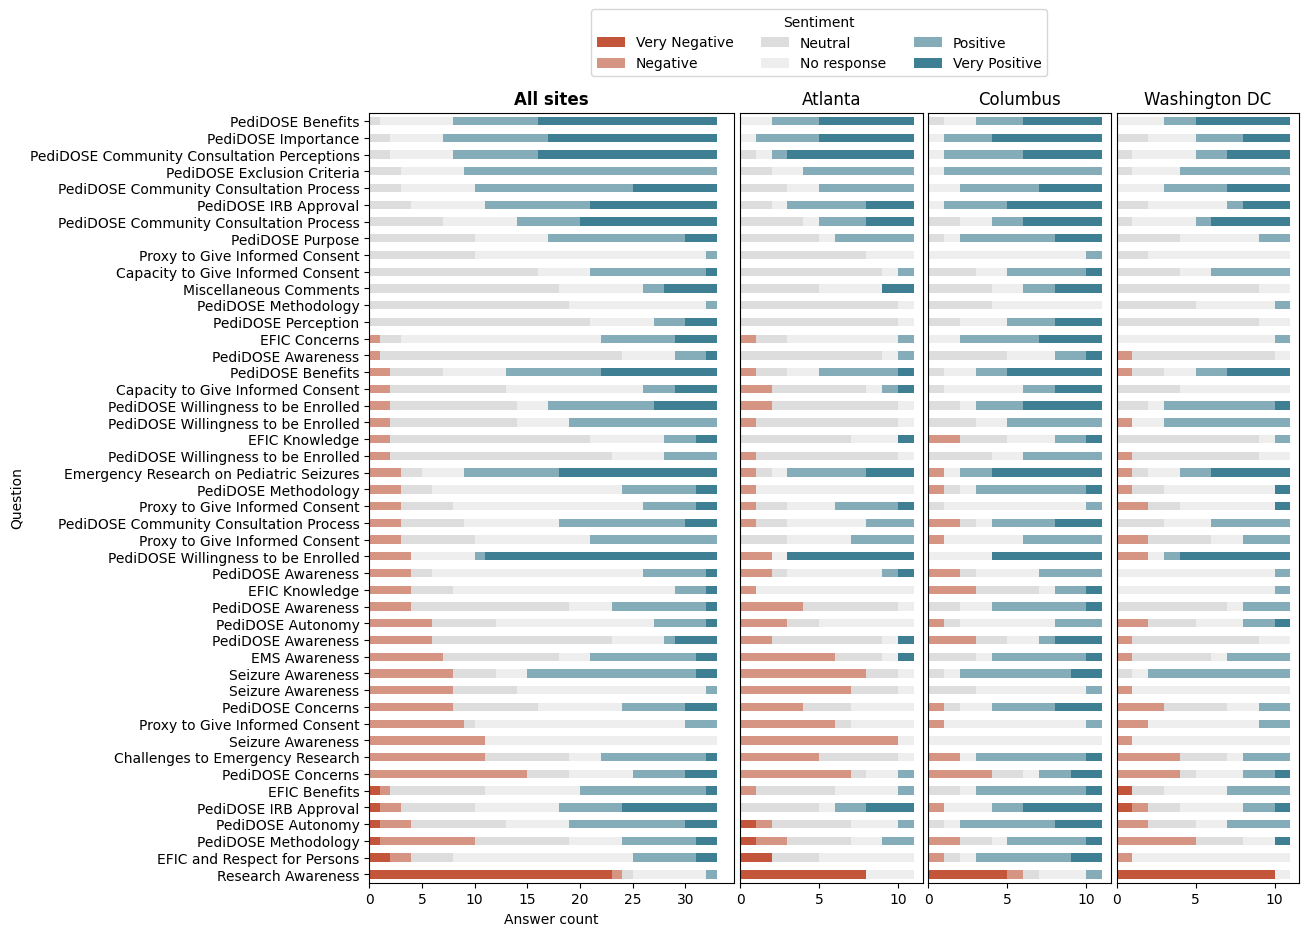

In [60]:
from matplotlib.gridspec import GridSpec

# make plot
sum_df = sum_df.sort_values(by=levels, ascending=False)
sum_index_sorted = sum_df.index
colors = sns.diverging_palette(20, 220, n=6).as_hex()
colors = colors[:2] + ['#ddd', '#eee'] + colors[-2:]

# make grid of 4 side-by-size plots with first plot being twice as wide
fig = plt.figure(figsize=(12, 10))

# remove spacing between plots
gs = GridSpec(1, 4, width_ratios=[2, 1, 1, 1], wspace=0.025)
ax1 = fig.add_subplot(gs[0])

sum_df.plot(kind='barh', stacked=True, color=colors, ax=ax1, legend=False)
plt.yticks(range(46), labels=df['Domain'].values[sent_df.index.values])
fig.legend(bbox_to_anchor=(0.5, 0.95), loc='center', ncol=3, title='Sentiment')
plt.xlabel('Answer count')
plt.title('All sites', fontweight='bold')

for i, site in enumerate(sites):
    ax = fig.add_subplot(gs[i+1])
    sent_df = sent_dfs[i]
    sent_df = sent_df.reindex(sum_index_sorted)
    sent_df.plot(kind='barh', stacked=True, color=colors, ax=ax, legend=False)
    plt.yticks([])
    plt.ylabel('')
    plt.title(data.RENAME_SITE_DICT.get(site, site))
plt.savefig(f'../figs/sentiment_agg.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# no limit display
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    # display(df[['Domain', 'Subcategory']])
    df[['Domain', 'Subcategory']].to_csv('../figs/question_list.csv')